# GPU 설정

In [ ]:
## GPU 사용시, GPU를 먼저 선택 후, 아래 코드(구글 드라이브 마운팅) 실행해야함!!!
# # 초기 1회 실행
# from google.colab import drive
# drive.mount('/content/drive')
# 코드 실행

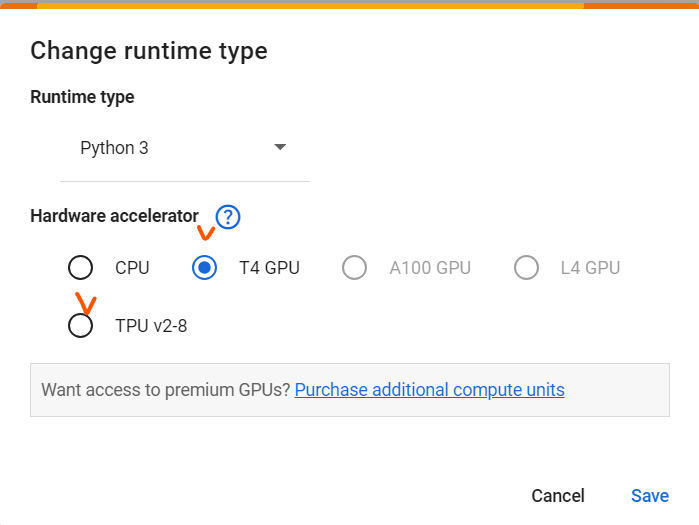

In [ ]:
import torch
## Google Colab에서 GPU 사용 설정, gpu가 있으면 gpu 사용, 아니면 cpu  사용
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [ ]:
# import torch

# 사용 가능한 GPU가 몇 개인지 확인
gpu_count = torch.cuda.device_count()

# 각 GPU에 대한 정보 출력
for i in range(gpu_count):
    gpu_name = torch.cuda.get_device_name(i)
    print(f"GPU {i}: {gpu_name}")
    print(f"총 멀티프로세서 수: {torch.cuda.get_device_capability(i)}")  # Compute Capability 확인
    print("멀티프로세서 =/= 코어수 ")

GPU 0: NVIDIA L4
총 멀티프로세서 수: (8, 9)
멀티프로세서 =/= 코어수 


In [ ]:
# 초기 1회 실행
# from google.colab import drive
# drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 📥 데이터 다운로드 (Download Dataset)
# GitHub에서 csv 파일을 다운로드합니다.

!wget https://raw.githubusercontent.com/Dropthe-bit/ai_portfolio/main/data/iris.csv

# Deep Learning2_ae

In [ ]:
## 필요 패키지 설치 및 import
import importlib.util
import subprocess
import sys
def install_and_import(packages):
    for pkg in packages:
        package = pkg
        try:
            importlib.util.find_spec(package)
            print(f"{package} is already installed.")
        except ImportError:
            # 모듈이 설치되어 있지 않은 경우 설치시도
            print(f"{package} is not installed. Installing...")
            subprocess.check_call([sys.executable, "-m", "pip", "install", package])
            subprocess.check_call([sys.executable, "!", "pip", "install", package])
            subprocess.check_call(["conda", "install", package, "-y"])

            # 설치 후 다시 임포트를 시도
            importlib.import_module(package)
            print(f"{package} has been successfully installed.")

        # finally:
        #     globals()[package] = importlib.import_module(package)
        except Exception as e:
            # 설치 중 예외가 발생한 경우, 에러 메시지를 출력
            print(f"An error occurred while installing {package}: {str(e)}")

# 예시 사용법
# install_and_import([''])


In [ ]:
## 필요 모듈 임포트
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets

In [ ]:
from sklearn.model_selection import train_test_split

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

### 데이터 읽기

In [ ]:
data = pd.read_csv("iris.csv")
data

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,virginica
146,6.3,2.5,5.0,1.9,virginica
147,6.5,3.0,5.2,2.0,virginica
148,6.2,3.4,5.4,2.3,virginica


### 전처리

In [ ]:
X = data.drop('species', axis=1)
y = data['species']

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                                                                   test_size = 0.3,
                                                                                                   random_state = 123)

In [ ]:
## 데이터 표준화
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Autoencoder

## 파이토치

In [ ]:
## 재현을 위한 랜덤 시드 고정...
import random
import numpy as np
import torch

## 랜덤 시드 고정 함수 정의
def set_seed(seed):
  ## 시드 고정
  random.seed(seed)                 # Python 기본 랜덤 시드 고정
  np.random.seed(seed)           # NumPy 랜덤 시드 고정
  torch.manual_seed(seed)     # PyTorch CPU 시드 고정

  ## GPU가 있는 경우 시드 고정, GPU 연산에서 사용되는 난수 생성기의 시드를 고정
  if torch.cuda.is_available():
      torch.cuda.manual_seed(seed)
      torch.cuda.manual_seed_all(seed)  # 모든 GPU에서 시드 고정

  ## CuDNN 설정 (GPU 사용 시), CuDNN 라이브러리의 비결정적 연산을 방지,  동일한 결과를 얻기 위한 설정..
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False


## 시드 고정
set_seed(123)  # 원하는 시드 값 설정


### 파이토치 데이터 형식으로 변환
- df, np.array to Tensor 형태

In [ ]:
## NumPy 배열을 PyTorch 텐서로 변환
X_train_tensor = torch.FloatTensor(X_train_scaled)
X_test_tensor = torch.FloatTensor(X_test_scaled)

X_train_tensor.shape, X_test_tensor.shape

(torch.Size([105, 4]), torch.Size([45, 4]))

### 모델 정의

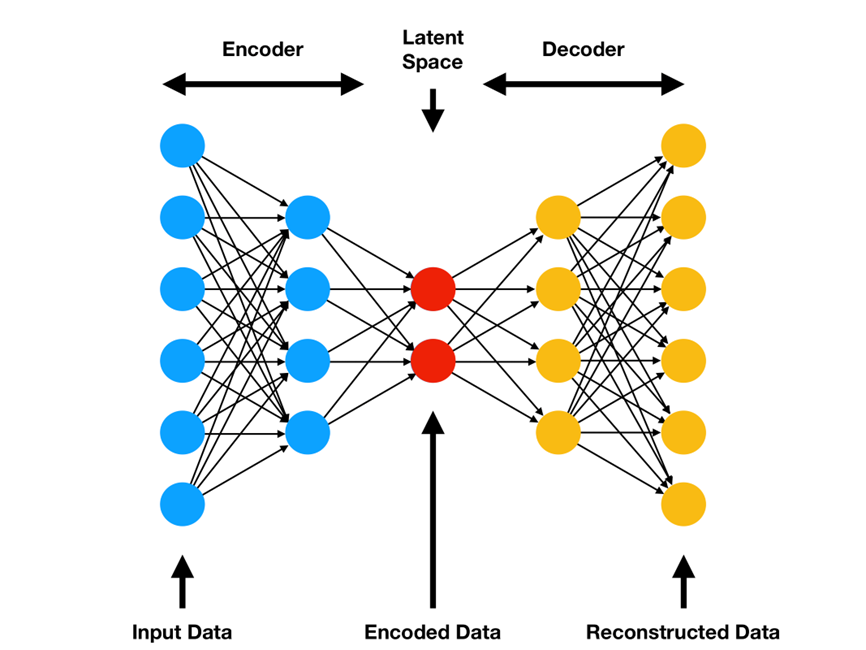

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self,  input_size, hidden_size = 3, intermediate_size = 2):
        super(Autoencoder, self).__init__()

        ## 인코더
        self.encoder = nn.Sequential(
                                                                    nn.Linear(input_size, hidden_size),
                                                                    nn.ReLU(True),
                                                                    nn.Dropout(0.1),  # 드롭아웃 추가
                                                                    nn.Linear(hidden_size, intermediate_size),  # 중간 레이어 차원 축소 (2차원) # Latent Space
                                                                    nn.ReLU(True)
        )

        ## 디코더
        self.decoder = nn.Sequential(
                                                                      nn.Linear(intermediate_size, hidden_size),
                                                                      nn.ReLU(True),
                                                                      nn.Dropout(0.1),  # 드롭아웃 추가
                                                                      nn.Linear(hidden_size, input_size)
        )

    def forward(self, x):

        x = self.encoder(x)
        x = self.decoder(x)

        return x


### 모델 초기화

In [ ]:
## 하이퍼파라미터 설정
input_size = X_train.shape[1] # 4
hidden_size = 3
intermediate_size = 2

## 모델 초기화
model = Autoencoder(input_size, hidden_size, intermediate_size).to(device)
model

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3, out_features=2, bias=True)
    (4): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3, out_features=4, bias=True)
  )
)

In [ ]:
## 모델의 파라미터 수 계산
total_params = sum(p.numel() for p in model.parameters())
print(f"Total number of parameters: {total_params}")

Total number of parameters: 48


### 모델 구조 확인

In [ ]:
# !pip install torchsummary
from torchsummary import summary

## 모델 구조 출력
summary(model, input_size=(X_train.shape[1], ))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                    [-1, 3]              15
              ReLU-2                    [-1, 3]               0
           Dropout-3                    [-1, 3]               0
            Linear-4                    [-1, 2]               8
              ReLU-5                    [-1, 2]               0
            Linear-6                    [-1, 3]               9
              ReLU-7                    [-1, 3]               0
           Dropout-8                    [-1, 3]               0
            Linear-9                    [-1, 4]              16
Total params: 48
Trainable params: 48
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
-----------------------------------------------------

### 트레이닝 함수 정의

In [ ]:
from torch.utils.data import DataLoader

## 학습 함수 정의
def train_model(model: nn.Module,
                                  train_loader: DataLoader,
                                  criterion: nn.Module,
                                  optimizer: optim.Optimizer,
                                  num_epochs: int):

    model.train()  # 학습 모드로 전환
    loss_history = []

    for epoch in range(num_epochs):
        running_loss = 0.0
        for data in train_loader:
            inputs = data[0].to(device)

            # 순전파
            outputs = model(inputs)
            loss = criterion(outputs, inputs)  # 입력과 출력의 차이를 최소화

            # 역전파 및 최적화
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / len(train_loader)
        loss_history.append(epoch_loss)
        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

    return loss_history, model


### 가중치 초기화

In [ ]:
import torch.nn.init as init

## He 초기화 함수 정의
# relu 계열, 딥러닝에 더 적합
def initialize_weights_he(m):
    if isinstance(m, nn.Linear):
        init.kaiming_uniform_(m.weight, nonlinearity = 'relu')  # He 초기화 (uniform 분포)
        if m.bias is not None:
            init.zeros_(m.bias)                                                                       # 편향은 0으로 초기화

## 순서는 모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화 !!!!!
model.apply(initialize_weights_he)  # 가중치 초기화

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=4, out_features=3, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3, out_features=2, bias=True)
    (4): ReLU(inplace=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=3, bias=True)
    (1): ReLU(inplace=True)
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3, out_features=4, bias=True)
  )
)

### 손실 함수와 옵티마이저 정의


In [ ]:
## 손실 함수
criterion = nn.MSELoss()

## 옵티마이저
## adam > = Nadam(adam의 약간 개선 버전) == adadelta(메모리 문제있으면)
optimizer = optim.Adam(
        model.parameters(),      # 모델의 학습 가능한 파라미터 전달
        lr = 0.01,                               # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
        weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
        amsgrad = False               # AMSGrad 알고리즘(adam 개선 버전..)을 사용할지 여부, 기본값은 False
)
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

### 데이터 로더
- 데이터를 미니 배치 단위로 나누어 모델에 공급(feed) 하는 방법
- 셔플, 병렬 처리 등을 지원하며, 학습 속도를 최적화할때 필요
- 배치크기 정하기..
  - 보통 2의 승수로 선택 64, 128, 1024 등
  - 왕도가 없음..

In [ ]:
from torch.utils.data import DataLoader, TensorDataset

## TensorDataset 생성
dataset = TensorDataset(X_train_tensor)

# set_seed(123)
## 데이터로더 생성
train_loader = DataLoader(dataset,
                                                        batch_size = 16,
                                                        shuffle=True)

In [ ]:
## CPU 코어 개수 출력
cpu_cores = os.cpu_count()
cpu_cores

12

### 모델 학습
- 중요 순서는 __모델 초기화 -> 가중치 초기화 -> 옵티마이져 초기화__

In [ ]:
## 모델 학습
num_epochs = 80

## 재학습시에는 모델 + 옵티마이져 초기화 를 꼭 해줘야 함!!!!
# model = Autoencoder(input_size, hidden_size, intermediate_size).to(device)
# optimizer = optim.Adam(
#         model.parameters(),      # 모델의 학습 가능한 파라미터 전달
#         lr = 0.01,                               # learning rate, 파라미터 업데이트의 크기를 결정, 기본값은 0.001
#         weight_decay = 0,           # 가중치 감쇠 (L2 규제, weight decay), 기본값은 0
#         amsgrad = False               # AMSGrad 알고리즘(adam 개선 버전..)을 사용할지 여부, 기본값은 False
# )
## 그렇지 않으면 이전 학습에서 이미 학습한 가중치를 기반으로 계속 업데이트하게됨...이상한 결과가 나올 수 있다..

set_seed(123)

loss_history, trained_model = train_model(model = model,
                                                                                          train_loader = train_loader,
                                                                                          criterion = criterion,
                                                                                          optimizer = optimizer,
                                                                                          num_epochs = num_epochs)
loss_history, trained_model # 만약 AssertionError: can only test a child process 발생시 num_workers = 0으로 변경

Epoch [10/80], Loss: 0.6731
Epoch [20/80], Loss: 0.4422
Epoch [30/80], Loss: 0.3781
Epoch [40/80], Loss: 0.3706
Epoch [50/80], Loss: 0.4068
Epoch [60/80], Loss: 0.3763
Epoch [70/80], Loss: 0.3457
Epoch [80/80], Loss: 0.3123


([1.034093703542437,
  1.0081906829561507,
  0.9540872914450509,
  0.9120607035500663,
  0.9298362306186131,
  0.7995585118021283,
  0.7687691705567496,
  0.7439000947134835,
  0.7020314122949328,
  0.6730701667921883,
  0.5932550132274628,
  0.5593467482498714,
  0.5254076336111341,
  0.5446207267897469,
  0.5017364834036145,
  0.46588034927845,
  0.46477105149200987,
  0.4892347923346928,
  0.4909261039325169,
  0.4422373218195779,
  0.4463271030357906,
  0.37049674136298044,
  0.45978303040776936,
  0.4040232960666929,
  0.436950010912759,
  0.4431524340595518,
  0.3745111588920866,
  0.31488613145692007,
  0.35150560310908724,
  0.37810044842106955,
  0.39860126801899504,
  0.3880383861916406,
  0.37498351080077036,
  0.44317316583224703,
  0.4198727181979588,
  0.4066564696175711,
  0.35160142183303833,
  0.3989806728703635,
  0.3432041768516813,
  0.3706225114209311,
  0.3181739130190441,
  0.3661975764802524,
  0.34277372913701193,
  0.30478888537202564,
  0.37618163228034973,
 

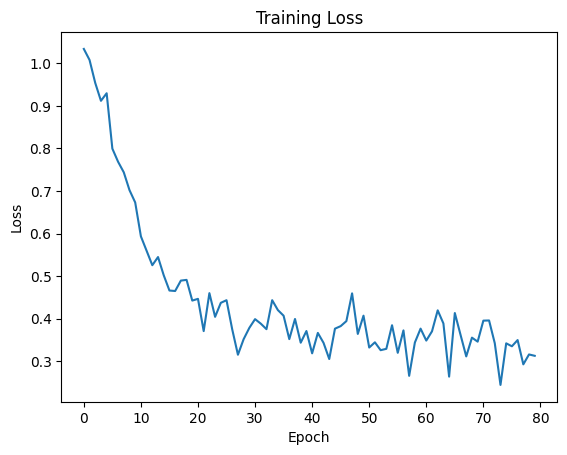

In [ ]:
## 에폭~Loss 그래프 그리기
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()

## 참고


### intermediate layer(Latent Space) 시각화(차원축소)

In [ ]:
## 학습 데이터에 대한 2차원 표현 추출
## 주의할 점은 학습할 때마다 결과가 다름....
trained_model.eval()
with torch.no_grad():
    encoded_data = trained_model.encoder(X_train_tensor.to(device)).cpu().numpy()


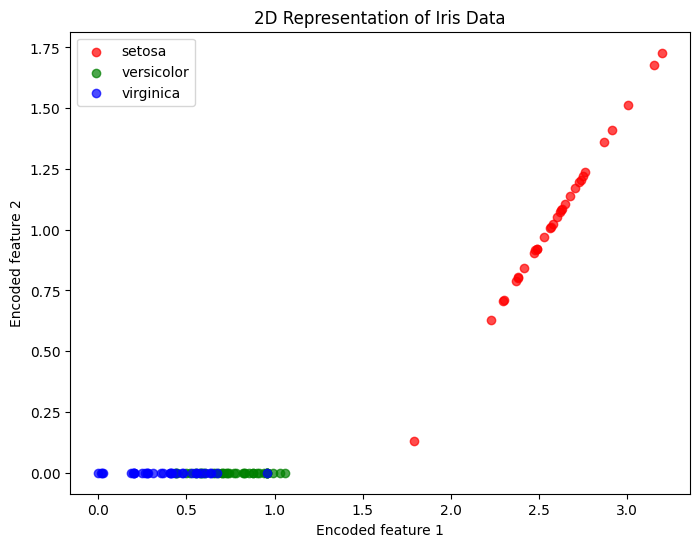

In [ ]:
## 클래스별로 색상 설정
colors = ['red', 'green', 'blue']
labels = y_train.copy()  # 훈련 데이터의 레이블 사용
labels = labels.reset_index(drop=True)  # 인덱스 재설정

## 고유한 레이블 값 가져오기
unique_labels = np.unique(labels)

plt.figure(figsize=(8, 6))
for i, color in zip(unique_labels, colors):

    ## 해당 클래스의 데이터만 선택하여 그리기
    plt.scatter(encoded_data[labels == i, 0], encoded_data[labels == i, 1],
                           label = i,
                           alpha = 0.7,
                           color = color)

plt.xlabel('Encoded feature 1')
plt.ylabel('Encoded feature 2')
plt.title('2D Representation of Iris Data')
plt.legend()
plt.show()

###  파라미터 갯수 , 가중치 출력하기

In [ ]:
## 파라미터 개수를 계산하는 함수 정의
def count_parameters(model):
    # 모델의 학습 가능한 파라미터 중, 각각의 파라미터의 요소 개수를 모두 더하기
    params = [param.numel() for param in model.parameters() if param.requires_grad]
    output = sum(params)

    return output

## 모델의 총 학습 가능한 파라미터 수를 계산하여 출력
total_params = count_parameters(trained_model)
print('Total parameters:' , total_params )

Total parameters: 48


In [ ]:
## 모델의 가중치와 편향을 출력하고, 각 레이어별 파라미터 정보를 출력하는 코드
for name, params in trained_model.named_parameters(): # 모델의 모든 파라미터를 이름과 함께 반환..

    if params.requires_grad:  # 파라미터가 학습 가능한 경우 (requires_grad=True)
        # 레이어 이름, 파라미터의 크기(모양), 파라미터 값 일부를 출력
        print(f'Layer: {name} \n | Size: {params.size()} \n | Values : {params[:2]}\n')


Layer: encoder.0.weight 
 | Size: torch.Size([3, 4]) 
 | Values : tensor([[-0.4595,  0.6182, -0.5590, -0.5975],
        [ 0.4849,  0.1149,  0.3988,  0.3726]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Layer: encoder.0.bias 
 | Size: torch.Size([3]) 
 | Values : tensor([0.1899, 0.3473], device='cuda:0', grad_fn=<SliceBackward0>)

Layer: encoder.3.weight 
 | Size: torch.Size([2, 3]) 
 | Values : tensor([[ 0.5809, -0.3770, -0.1928],
        [ 0.6593,  0.0818,  0.0061]], device='cuda:0',
       grad_fn=<SliceBackward0>)

Layer: encoder.3.bias 
 | Size: torch.Size([2]) 
 | Values : tensor([ 0.9555, -0.8150], device='cuda:0', grad_fn=<SliceBackward0>)

Layer: decoder.0.weight 
 | Size: torch.Size([3, 2]) 
 | Values : tensor([[-1.0780, -0.6381],
        [ 0.9948, -0.3794]], device='cuda:0', grad_fn=<SliceBackward0>)

Layer: decoder.0.bias 
 | Size: torch.Size([3]) 
 | Values : tensor([ 0.8948, -0.3353], device='cuda:0', grad_fn=<SliceBackward0>)

Layer: decoder.3.weight 
 | Size: tor

## 재구성 오류
- reconstrunction error
- 이상치 탐지에 활용가능

### 학습 데이터

In [ ]:
## 랜덤 샘플 선택
num_samples = 3
sample_indices = np.arange(num_samples)

## 원본데이터와 재구성된 데이터
trained_model.eval()
with torch.no_grad():
    reconstructed = trained_model(X_train_tensor.to(device)).cpu().numpy()

original_samples = X_train_scaled[sample_indices]
reconstructed_samples = reconstructed[sample_indices]

In [ ]:
## 오리지날 데이터
pd.DataFrame(original_samples, columns = X_train.columns)

,sepal_length,sepal_width,petal_length,petal_width
0,-0.087756,-0.615256,0.740209,1.587111
1,0.543367,0.858551,1.033278,1.587111
2,-0.466430,-1.843427,0.095457,0.091913


In [ ]:
## 복원된 데이터
pd.DataFrame(reconstructed_samples, columns = X_train.columns)

,sepal_length,sepal_width,petal_length,petal_width
0,0.507079,-0.301877,0.584048,0.559001
1,0.987858,-0.167061,0.948948,0.927662
2,-0.197108,-0.493642,0.030695,0.002695


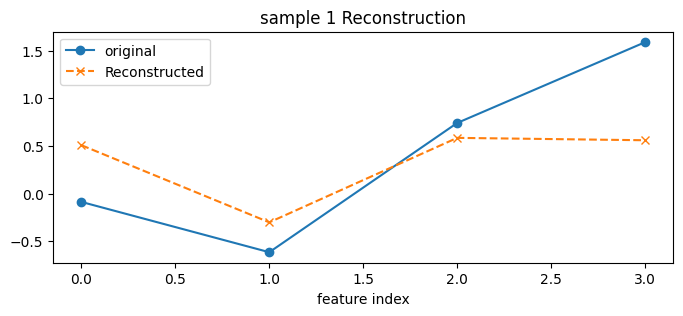

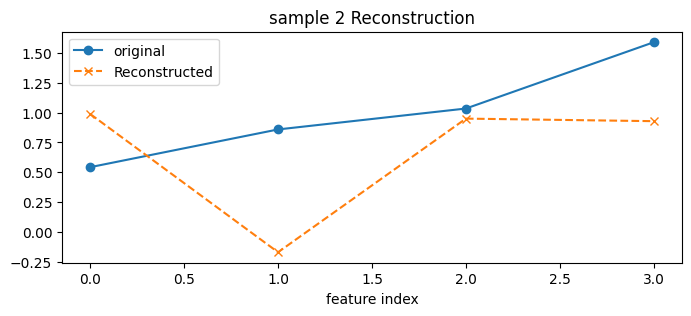

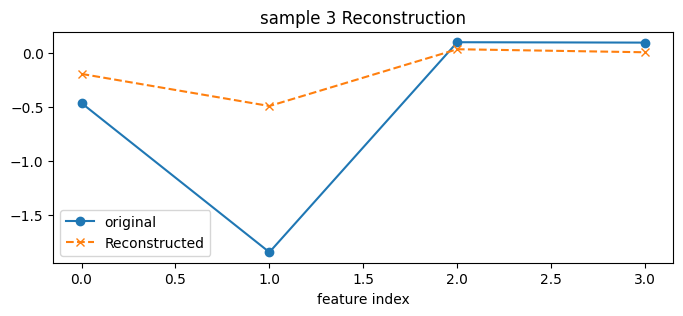

In [ ]:
## 오리지날 데이터와 재구성된 데이터 비교
for i in range(num_samples):
    plt.figure(figsize = (8, 3))
    plt.plot(original_samples[i], 'o-', label = 'original')
    plt.plot(reconstructed_samples[i], 'x--', label = 'Reconstructed')
    plt.title(f'sample {i+1} Reconstruction')
    plt.xlabel('feature index') # X_train.columns 순서
    plt.legend()
    plt.show()

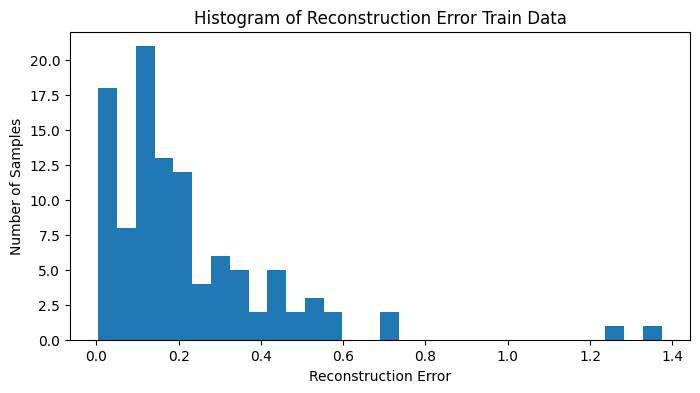

In [ ]:
## 재구성 오류 계산 (MSE)
reconstruction_error = np.mean((X_train_scaled - reconstructed) ** 2, axis=1)

## 히스토그램 시각화
plt.figure(figsize = (8, 4))
plt.hist(reconstruction_error, bins=30)
plt.xlabel('Reconstruction Error')
plt.ylabel('Number of Samples')
plt.title('Histogram of Reconstruction Error Train Data')
plt.show()


### 테스트 데이터
- 만약 정상 데이터만 학습했다고 가정한다면..
- 테스트 데이터의 재구성 오차가 큰 데이터는 이상치일 가능성이 크다!

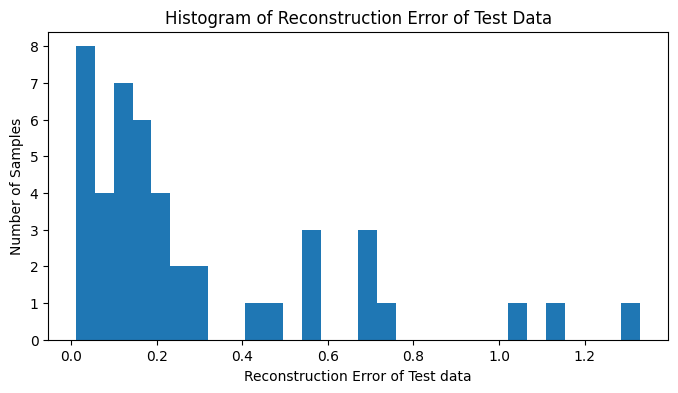

In [ ]:
## 테스트 데이터에 대한 재구성 오차 계산
trained_model.eval()
with torch.no_grad():
    reconstructed = trained_model(X_test_tensor.to(device)).cpu().numpy()

original_data_test = X_test_scaled
reconstructed_data_test = reconstructed

## 재구성 오차 계산 (MSE)
reconstruction_error_test = np.mean((X_test_scaled - reconstructed_data_test) ** 2, axis=1)

## 히스토그램 시각화
plt.figure(figsize=(8, 4))
plt.hist(reconstruction_error_test, bins=30)
plt.xlabel('Reconstruction Error of Test data')
plt.ylabel('Number of Samples')
plt.title('Histogram of Reconstruction Error of Test Data')
plt.show()


In [ ]:
## 이상치 찾기
reconstruction_error_test_df = pd.Series(reconstruction_error_test)
scores = reconstruction_error_test_df[reconstruction_error_test_df > 1]

## 의심되는 친구들..
X_test.iloc[scores.index, :]

,sepal_length,sepal_width,petal_length,petal_width
117,7.7,3.8,6.7,2.2
131,7.9,3.8,6.4,2.0
60,5.0,2.0,3.5,1.0


In [ ]:
# EOS